# Data Wrangling project (WeRateDogs)
## Table of Content
>- [Introduction]()
>- [Gathering]()
>- [Accessing]()
>- [Cleaning]()
>- [visualization]()

## Introduction
>This project involves the analysis of tweets archive of Twitter user [*@dog_rates*](), also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." 

> In this project, we will be covering all the data wrangling process(*gathering, accessing, cleaning and visualization*) as it is a great skill required of a good data analyst. This will be used to answer certain questions like:
>- what dog stage had the highest favorite count?
>- what year and month did the highest tweets occur?
>- what is the most frequent tweet source?
>- what are the predicted dog with the highest favorite count?
>- Is there any relationship between the favorite_count and retweet_count?

## Gathering

> In this section, the required dataframes needed for this analysis will be gathered, and they are as follows:
> 1. **the twitter archive data (*'[twitter-archive-enhanced (1).csv]()'*) which is to be downloaded using the python read_csv command:** this contains basic tweet data for all 5000+ of their tweets, but not everything. It has been filtered for tweets with ratings only, resulting to 2356 tweets.

> 2. **the image prediction data** (*'image-predictions.tsv'*) which will be downloaded programmatically from the 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv' url. This classifies what breed of dog that is present in each tweet according to the previously created neural network.

> 3. **Additional data via twitter API:** there are data omissions (*retweet count and favorite count*) found in the twitter archive data, which will be gotten by querying the twitter API. Using the tweet IDs in the WeRateDogs Twitter archive, the Twitter API for each tweet's JSON data will be queried using Python's Tweepy library and each tweet's entire set of JSON data will be stored in a file called tweet_json.txt file. Each tweet's JSON data would be written to its own line. Then the .txt file read line by line into a pandas DataFrame with tweet ID, retweet count, and favorite count.


> **Now it's time to dive into the data wranglinging process**

In [1]:
#importing all modules needed
import pandas as pd
import numpy as np
import requests
import tweepy
from tweepy import OAuthHandler
from timeit import default_timer as timer
import json
import matplotlib.pyplot as plt
import re

#magic command
%matplotlib inline



In [2]:
#downloading the 'twitter-archive-enhanced (1).csv' file and storing it as a dataframe 'twitter_df'
twitter_df = pd.read_csv('twitter-archive-enhanced (1).csv', encoding = 'utf-8')
twitter_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


>  The twitter-archive-enhanced.csv data has successfully been read and stored as the twitter_df dataframe, having 2356 rows and 17 columns.

In [3]:
#using the request library to programmatically download the 'image-predictions.tsv' file.

url = ' https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
file = requests.get(url)
with open('image-predictions.tsv', mode = 'wb')as my_file:
    my_file.write(file.content)

#reading the 'image-predictions.tsv' file to a dataframe ('image_prediction') using the pandas library

image_prediction = pd.read_csv('image-predictions.tsv', sep = '\t')
image_prediction

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


> The image-predictions.tsv file has been successfully downloaded programmatically using the requests module, into the image predictions dataframe. It has 2075 rows and 12 columns.

> It's columns can be explained as follows:
>- 'tweet_id' is the last part of the tweet URL after "status/" → https://twitter.com/dog_rates/status/889531135344209921
>- 'p1' is the algorithm's #1 prediction for the image in the tweet → golden retriever
>- 'p1_conf' is how confident the algorithm is in its #1 prediction → 95%
>- 'p1_dog' is whether or not the #1 prediction is a breed of dog → TRUE
>- 'p2' is the algorithm's second most likely prediction → Labrador retriever
>- 'p2_conf' is how confident the algorithm is in its #2 prediction → 1%
>- 'p2_dog' is whether or not the #2 prediction is a breed of dog → TRUE etc.


In [ ]:
# Querying Twitter API for each tweet in the Twitter archive and saving the JSON in a text file
# The keys are hidden to comply with Twitter's API terms and conditions
consumer_key = '*****'
consumer_secret = '****'
access_token = '****'
access_secret = '****'


auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)


# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = twitter_df.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet-json (1).txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepyException as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856


In [4]:
#Reading the 'tweet_json.txt' file line by line into a pandas DataFrame with tweet ID, retweet count, and favorite count.
df_list =[]
with open('tweet-json (1).txt', 'r') as file:
    for line in file:
        data = json.loads(line)
        tweets = {'tweet_id': data['id'],
                 'retweet_count': data['retweet_count'],
                 'favorite_count': data['favorite_count']}
        df_list.append(tweets)
df_tweets = pd.DataFrame(df_list, columns = ['tweet_id', 'retweet_count', 'favorite_count'])

In [5]:
df_tweets.shape

(2354, 3)

>After using the twitter API, the df_tweets dataframe was dwonloaded using the tweepy module and read line by line as a JSON file into a dataframe.



# Accessing Data

> After gathering, the next thing is to access the data for tidiness and quality issues. The three datasets will be accessed visually and programmatically, to check for quality issues such as the case of missing data, incorrect data, inconsistencies and duplicate data, and also for tidiness issues such as specific structural issues.

In [6]:
#print the last 50 lines of the 'twitter_df' dataset to access it visually
twitter_df.head(50)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [7]:
#print the first 50 lines of the 'df_tweets' dataset to access it visually
df_tweets.head(50)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
5,891087950875897856,3261,20562
6,890971913173991426,2158,12041
7,890729181411237888,16716,56848
8,890609185150312448,4429,28226
9,890240255349198849,7711,32467


In [8]:
#print the first 50 lines of the 'image_prediction' dataset to access it visually
image_prediction.head(50)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [9]:
#Programmatic accessment of the dataframes

#looking at the overview of the 'twitter_df' dataframe
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [10]:
#looking at the overview of the 'df_tweets' dataframe
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [11]:
##looking at the overview of the 'image_prediction' dataframe
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [12]:
#printing random entries of the twitter_df text column
twitter_df['text'][2350]

'This is a truly beautiful English Wilson Staff retriever. Has a nice phone. Privileged. 10/10 would trade lives with https://t.co/fvIbQfHjIe'

In [13]:
twitter_df.shape

(2356, 17)

In [14]:
df_tweets.shape

(2354, 3)

In [15]:
image_prediction.shape

(2075, 12)

In [16]:
#using the .sample() method to investigate the rating_numerator and rating_denominator columns
twitter_df[['rating_numerator', 'rating_denominator']].tail(20)

,rating_numerator,rating_denominator
2336,11,10
2337,10,10
2338,1,10
2339,11,10
2340,8,10
2341,9,10
2342,6,10
2343,10,10
2344,9,10
2345,10,10


In [17]:
#checking for duplicate values in the twitter_df dataframe
twitter_df.duplicated().sum()

0

In [18]:
#checking for duplicate values in the df_tweets dataframe
df_tweets.duplicated().sum()

0

In [19]:
#checking for duplicate values in the image_prediction dataframe
image_prediction['tweet_id'].duplicated().sum()

0

In [20]:
#checking for duplicate values in the df_tweets['tweet_id'] series
df_tweets.tweet_id.duplicated().sum()

0

In [21]:
#checking for duplicate values in the image_prediction dataframe
image_prediction['jpg_url'].duplicated().sum()

66

In [22]:
#checking for duplicate values in the twitter_df['expanded_urls'] series
twitter_df['expanded_urls'].duplicated().sum()

137

In [23]:
#checking a sample jpg_url subset dataframe
image_prediction[image_prediction['jpg_url'] == 'https://pbs.twimg.com/media/CZhn-QAWwAASQan.jpg']

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
800,691416866452082688,https://pbs.twimg.com/media/CZhn-QAWwAASQan.jpg,1,Lakeland_terrier,0.530104,True,Irish_terrier,0.197314,True,Airedale,0.082515,True
1624,803692223237865472,https://pbs.twimg.com/media/CZhn-QAWwAASQan.jpg,1,Lakeland_terrier,0.530104,True,Irish_terrier,0.197314,True,Airedale,0.082515,True


## Quality issues

#### Twitter_df dataframe

>- Only original tweets with images are needed for our anlaysis(not retweets) so columns like 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp' are not needed.
>- The 'in_reply_to_status_id' and 'in_reply_to_user_id' column, having non null rows are not needed, as they are not original
tweets.
>- The timestamp column are meant to be datetime datatype and not object.
>-  The 'tweet_id' will be changed to string datatype as they won't be needed for any mathematical operations in our analysis.
>- Columns such as the 'doggo', 'floofer', 'pupper', and 'puppo', contains None values, which is meant to be read as NaN values.
>- It is also noticed that the 'name' column contains incorrect names such as 'None', 'a', 'quite', 'an', 'the', 'such' etc.
>- The source column should be cleaned to extract the main source of the data(device type).
>- The '*expanded_urls*' column has duplicate entries.

#### df_tweets dataframe
>- The 'tweet_id' will be changed to a string datatype instead of being an integer


#### Image_prediction dataframe
>- The '*jpg_url*' column has duplicate entries corresponding to the different tweet_ids.
>- The 'tweet_id' will be changed to a string datatype instead of being an integer

## Tidiness Issues

>- The datasets should be merge into one for analysis.
>- The dog stages('doggo', 'floofer', 'pupper', and 'puppo') are meant to be in rows not columns

# Cleaning
> Now its time to dive into cleaning our data using the quality and tidiness issues mentioned above.

In [24]:
#We start by making copies of our dataframes
twitter_df_copy = twitter_df.copy()
image_prediction_copy = image_prediction.copy()
df_tweets_copy = df_tweets.copy()

### Twitter_df
#### Define
> Starting with tidiness, we need to melt the dataframe to  the change 'doggo', 'floofer', 'pupper', and 'puppo' columns into rows for our analysis.

#### Code

In [25]:
# Select the columns that will be changed to rows
stage_columns = ['doggo', 'floofer', 'pupper', 'puppo']
#melt the columns to rows
twitter_data_copy = pd.melt(twitter_df_copy, id_vars = ['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name'],  var_name = 'stages', value_vars = stage_columns, value_name = 'dog_stages')

In [26]:
#dropping the duplicate columns obtained after the melting
twitter_data_copy = twitter_data_copy.sort_values('dog_stages').drop_duplicates('tweet_id', keep = 'last')

In [27]:
#investigating the dog_stages columns
twitter_data_copy['dog_stages'].value_counts()

None       1976
pupper      257
doggo        83
puppo        30
floofer      10
Name: dog_stages, dtype: int64

In [28]:
#investigating the stages column 
twitter_data_copy['stages'].value_counts()

floofer    1755
doggo       313
pupper      257
puppo        31
Name: stages, dtype: int64

In [29]:
#dropping the twitter_data 'stages' column
twitter_data_copy = twitter_data_copy.drop('stages', axis = 1)

#### Test

In [30]:
#inspecting the dropped column
twitter_data_copy.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'dog_stages'],
      dtype='object')

#### Define
> Extract the rows with the null 'in_reply_to_status_id' column as it is required for the analysis

#### Code

In [31]:
#extracting the rows with the null 'in_reply_to_status_id' , 'in_reply_to_user_id.isna()' columns
twitter_data_copy  = twitter_data_copy.query(('in_reply_to_status_id.isna()'  and 'in_reply_to_user_id.isna()'))

In [32]:
#extracting the rows with the null retweet columns as the non null are not needed for our analysis
twitter_data_copy  = twitter_data_copy.query(('retweeted_status_user_id.isna()'  and 'retweeted_status_timestamp.isna()' and 'retweeted_status_id.isna()'))

In [33]:
#dropping the retweet columns which are not needed for our analysis
twitter_data_copy.drop(['retweeted_status_user_id', 'retweeted_status_timestamp', 'retweeted_status_id', 'in_reply_to_status_id', 'in_reply_to_user_id'], axis = 1, inplace = True)

#### Test

In [34]:
#checking if the columns have been been dropped
twitter_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 2261 to 7236
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2097 non-null   int64 
 1   timestamp           2097 non-null   object
 2   source              2097 non-null   object
 3   text                2097 non-null   object
 4   expanded_urls       2094 non-null   object
 5   rating_numerator    2097 non-null   int64 
 6   rating_denominator  2097 non-null   int64 
 7   name                2097 non-null   object
 8   dog_stages          2097 non-null   object
dtypes: int64(3), object(6)
memory usage: 163.8+ KB


In [36]:
twitter_data_copy.shape

(2097, 9)

#### Define
> Changing the 'tweet_id' and 'timestamp' columns datatypes into string and datetime respectively

#### Code

In [37]:
#changing the tweet_id column to string datatype
twitter_data_copy['tweet_id'] = twitter_data_copy['tweet_id'].astype('string')

#changing the timestamp column to datetime datatype
twitter_data_copy['timestamp'] = pd.to_datetime(twitter_data_copy['timestamp'])

#### Test

In [38]:
twitter_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 2261 to 7236
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2097 non-null   string             
 1   timestamp           2097 non-null   datetime64[ns, UTC]
 2   source              2097 non-null   object             
 3   text                2097 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2097 non-null   int64              
 6   rating_denominator  2097 non-null   int64              
 7   name                2097 non-null   object             
 8   dog_stages          2097 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(2), object(5), string(1)
memory usage: 163.8+ KB


#### Define
>Extract all incorrect names such as 'a', 'the', 'such' etc. and replace them with 'None'.

#### Code

In [39]:
#inspecting the name entries with incorrect names
list1 = []
for a in twitter_data_copy['name']:
    if a.islower():
        list1.append(a)
list1

['a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'the',
 'a',
 'a',
 'a',
 'an',
 'a',
 'an',
 'the',
 'the',
 'a',
 'quite',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'an',
 'such',
 'getting',
 'a',
 'a',
 'an',
 'very',
 'a',
 'the',
 'a',
 'a',
 'getting',
 'very',
 'this',
 'unacceptable',
 'old',
 'a',
 'infuriating',
 'just',
 'light',
 'space',
 'a',
 'the',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'an',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'by',
 'officially',
 'actually',
 'a',
 'a',
 'a',
 'life',
 'a',
 'the',
 'a',
 'a',
 'incredibly',
 'quite',
 'quite',
 'not',
 'one',
 'very',
 'not',
 'a',
 'my',
 'a',
 'an',
 'very',
 'one',
 'a',
 'a',
 'his',
 'one',
 'mad',
 'just',
 'a',
 'a',
 'actually',
 'all',
 'just',
 'the',
 'one',
 'a',
 'the',
 'a']

In [40]:
#using regular expression to extract all incorrect name entries(all are lower cases)
twitter_data_copy[[twitter_data_copy['name'].str.match('[a-z]+')]] = 'None'

#### Test

In [41]:
#checking for those incorrect entries such as 'a'
twitter_data_copy[twitter_data_copy['name']== 'a']

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages


#### Define
>- Clean the source code by removing the tags 
>- Drop the duplicate 'expanded_urls'

#### Code

In [42]:
# Clean the source column
twitter_data_copy['source'] = twitter_data_copy['source'].apply(lambda x: re.findall(r'>(.*)<', x))


In [43]:
#dropping the text column
twitter_data_copy = twitter_data_copy.drop('text', axis = 1)

In [44]:
#dropping the duplicated 'expanded_urls' column 
twitter_data_copy = twitter_data_copy.drop_duplicates('expanded_urls')

#### Test

In [45]:
#checking the twitter_data overview
twitter_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1992 entries, 2261 to 7236
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            1992 non-null   string
 1   timestamp           1992 non-null   object
 2   source              1992 non-null   object
 3   expanded_urls       1991 non-null   object
 4   rating_numerator    1992 non-null   object
 5   rating_denominator  1992 non-null   object
 6   name                1992 non-null   object
 7   dog_stages          1992 non-null   object
dtypes: object(7), string(1)
memory usage: 140.1+ KB


### df_tweets

#### Define
>Convert the 'tweet_id' column to string datatype

#### Code

In [46]:
#Convert the 'tweet_id' column to string datatype
df_tweets_copy['tweet_id'] = df_tweets_copy['tweet_id'].astype('string')

#### Test 

In [47]:
#checking the df_tweets dataframe overview
df_tweets_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2354 non-null   string
 1   retweet_count   2354 non-null   int64 
 2   favorite_count  2354 non-null   int64 
dtypes: int64(2), string(1)
memory usage: 55.3 KB


### Image_prediction 
#### Define
>- Obtain the highest prediction confidence with the prediction being True from the 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf' and 'p3_dog' columns.
>- drop the duplicate 'jpg_url' rows.


#### Code

In [49]:
#Obtain the highest prediction confidence with the prediction being True from the 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf' and 'p3_dog' columns.
prediction_confidence = []
predicted_dog = []
def image_predict(data):
    if data['p1_dog'] == True:
        predicted_dog.append(data['p1'])
        prediction_confidence.append(data['p1_conf'])
    elif data['p2_dog'] == True:
        predicted_dog.append(data['p2'])
        prediction_confidence.append(data['p2_conf'])
    else:
        predicted_dog.append('NaN')
        prediction_confidence.append('NaN')

#attach the 'prediction_confidence', 'predicted_dog' columns to the image_prediction dataframe
image_prediction_copy.apply(image_predict, axis=1)
image_prediction_copy['prediction_confidence'] = prediction_confidence
image_prediction_copy['predicted_dog'] = predicted_dog

In [50]:
#drop the prediction columns
image_prediction_copy.drop(columns = ['p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], axis = 1, inplace = True)

In [51]:
#replace with np.NaN
image_prediction_copy[['prediction_confidence', 'predicted_dog']] = image_prediction_copy[['prediction_confidence', 'predicted_dog']].replace('NaN', np.NaN)

In [52]:
#check for missing values
image_prediction_copy.isna().sum()

tweet_id                   0
jpg_url                    0
img_num                    0
prediction_confidence    388
predicted_dog            388
dtype: int64

In [53]:
#drop missing values
image_prediction_copy.dropna(inplace = True)

In [54]:
#multiply the 'prediction_confidence' percentage column by 100 for easy understanding
image_prediction_copy['prediction_confidence'] = image_prediction_copy['prediction_confidence']*100

In [55]:
#check for duplicated values 
image_prediction_copy['jpg_url'].duplicated().sum()

58

In [56]:
#dropping 'jpg_url' duplicate rows
image_prediction_copy = image_prediction_copy.drop_duplicates(['jpg_url'])

In [57]:
#changing the 'tweet_id' to string datatype
image_prediction_copy['tweet_id'] = image_prediction_copy['tweet_id'].astype('string')

C:\Users\Onyima Emmanuella\AppData\Local\Temp\ipykernel_3852\1606020471.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_prediction_copy['tweet_id'] = image_prediction_copy['tweet_id'].astype('string')


In [58]:
#merging the three dataframes 
Clean_data = pd.merge(pd.merge(twitter_data_copy,image_prediction_copy, on='tweet_id', how='inner'),df_tweets_copy, on='tweet_id', how='inner')

In [59]:
#replacing all 'None' values with 'NaN'
Clean_data = Clean_data.replace('None', np.NaN)

# Storing the Data

In [60]:
#storing the merged dataset
Clean_data.to_csv('twitter_archive_master.csv', encoding = 'utf-8', index = False)

In [61]:
#reading the twitter_archive_master dataset
twitter_archive_master = pd.read_csv('twitter_archive_master.csv')

In [62]:
twitter_archive_master.shape

(1530, 14)

# Data visualization
> **The following questions about the twitter_archive_master dataset will be answered**
>- what year and month did the highest tweets occur?
>- what date recorded the highest favorite tweet?
>- what is the most frequent tweet source?
>- what are the predicted dog with the highest favorite count?
>- What dog stage had the highest favorite counts?
>- Is there any relationship between the favorite_count and retweet_count?
>- Is there any relationship between the favorite_count and timestamp?

In [63]:
twitter_archive_master.describe(percentiles = [0.25, 0.5, 0.75, 0.9])

,tweet_id,rating_numerator,rating_denominator,img_num,prediction_confidence,retweet_count,favorite_count
count,1.530000e+03,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000
mean,7.418878e+17,11.382353,10.417647,1.220261,57.106699,2874.120915,9498.196732
std,6.836946e+16,6.892775,5.906627,0.581361,28.961471,4806.090265,12647.049891
min,6.660209e+17,0.000000,7.000000,1.000000,0.001003,16.000000,81.000000
25%,6.787988e+17,10.000000,10.000000,1.000000,33.131100,673.500000,2305.500000
50%,7.183534e+17,11.000000,10.000000,1.000000,57.309350,1497.000000,4581.000000
75%,7.961414e+17,12.000000,10.000000,1.000000,83.661700,3346.250000,12195.750000
90%,8.471666e+17,13.000000,10.000000,2.000000,95.958250,6479.900000,23443.300000
max,8.921774e+17,165.000000,150.000000,4.000000,99.995300,79515.000000,132810.000000


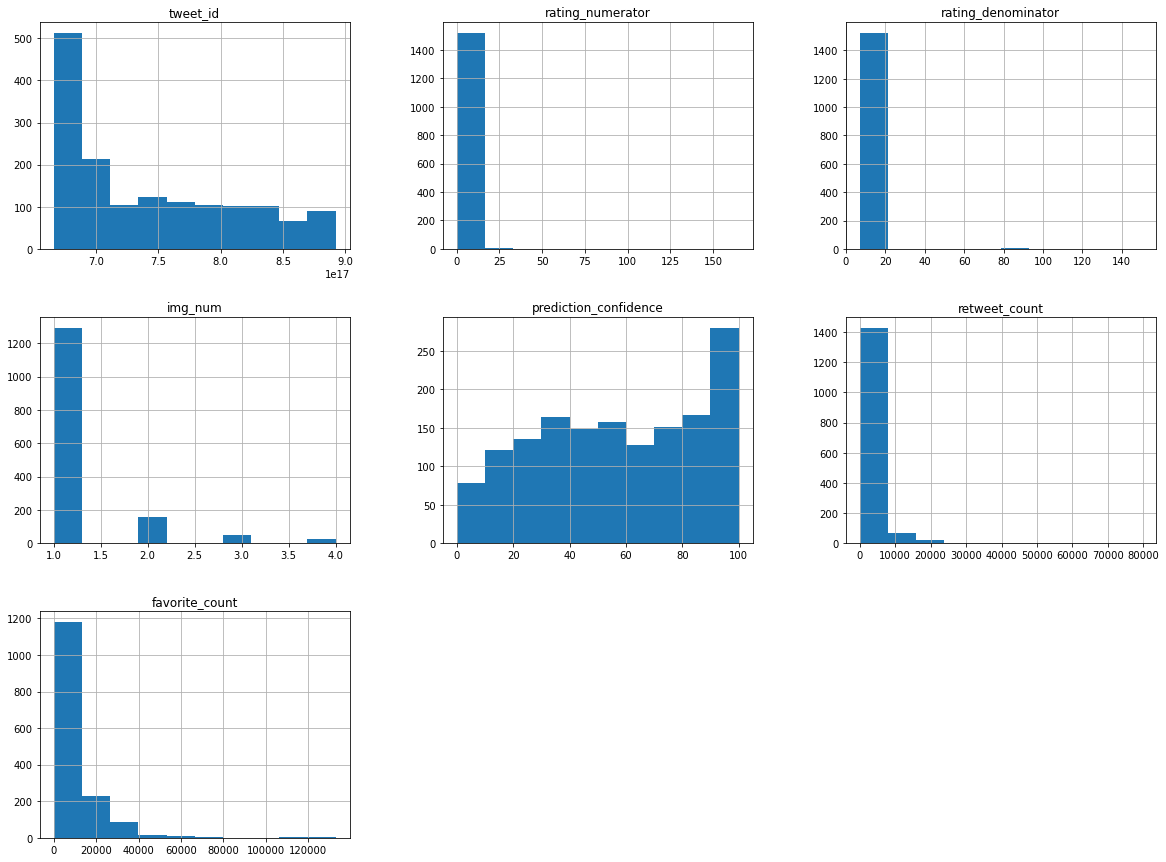

In [64]:
twitter_archive_master.hist(figsize = [20, 15]);

> From the description above the following information can be obtained
>- There is a average rating numerator and denominator of 11.335106	and 10.424867 respectively
>- There is a mean prediction confidence of 56.881594	
>- Half of the tweets had a favorite counts of 9195.031915 and retweet count of 2779.656915 having there grapghs to be left skewed

### 1. what year and month did the highest tweets occur?

In [65]:
twitter_archive_master['timestamp'] = pd.to_datetime(twitter_archive_master['timestamp'])

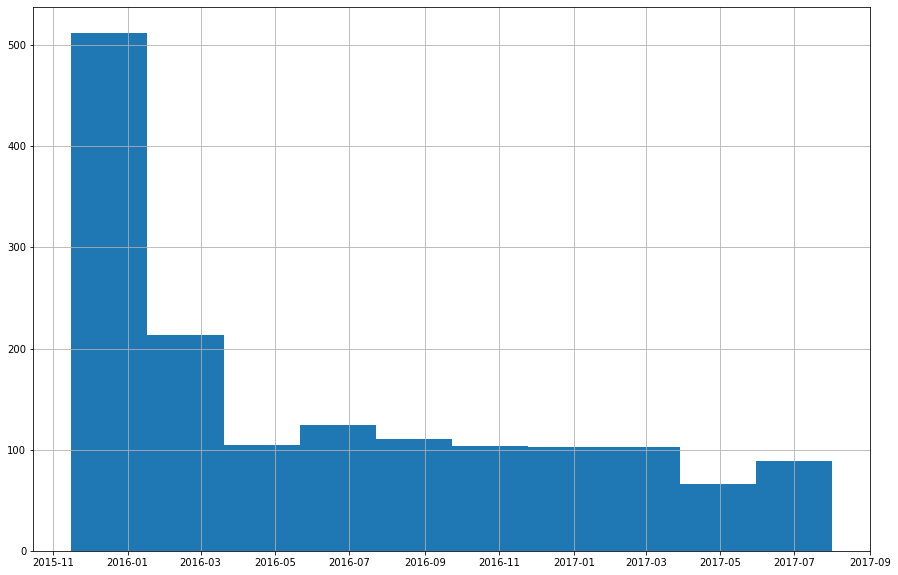

In [66]:
twitter_archive_master['timestamp'].hist(figsize = [15,10]);

> The highest tweets occured between the November 2015  to January 2016 and decreased across 2017

###  2. what date recorded the highest favorite tweet?

In [67]:
twitter_archive_master['favorite_count'].max()

132810

In [68]:
#inspecting the highest favorite count
twitter_archive_master[twitter_archive_master['favorite_count'] == 132810]

,tweet_id,timestamp,source,expanded_urls,rating_numerator,rating_denominator,name,dog_stages,jpg_url,img_num,prediction_confidence,predicted_dog,retweet_count,favorite_count
1520,822872901745569793,2017-01-21 18:26:02+00:00,['Twitter for iPhone'],https://twitter.com/dog_rates/status/822872901...,13,10,NaN,puppo,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg,1,19.6015,Lakeland_terrier,48265,132810


In [69]:
high_favorite_count_data = twitter_archive_master.query('(favorite_count == 132810) or (favorite_count == 131075) or (favorite_count == 107956) or (favorite_count == 107015) or (favorite_count == 95450)')

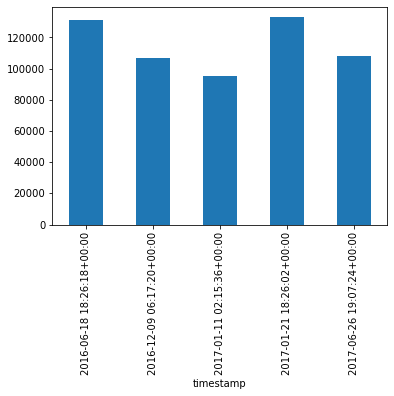

In [70]:
high_favorite_count_data.groupby('timestamp')['favorite_count'].mean().plot(kind = 'bar');

> The highest favorite tweets occured on the 21st of january 2017 (2017-01-21 18:26:02+00:00)

### what is the most frequent tweet source?

In [71]:
twitter_archive_master['source'].value_counts()

['Twitter for iPhone']    1503
['Twitter Web Client']      18
['TweetDeck']                9
Name: source, dtype: int64

> Most people used iphone for their tweets, with the highest tweet source of 1476

### 3. what are the predicted dog with the highest favorite count?

C:\Users\Onyima Emmanuella\AppData\Local\Temp\ipykernel_3852\2167648071.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  twitter_archive_master.groupby('predicted_dog')['retweet_count', 'favorite_count'].max().nlargest(5, 'favorite_count').plot(kind = 'bar', title = 'predicted dogs with highest retweet_count, and favorite_count');


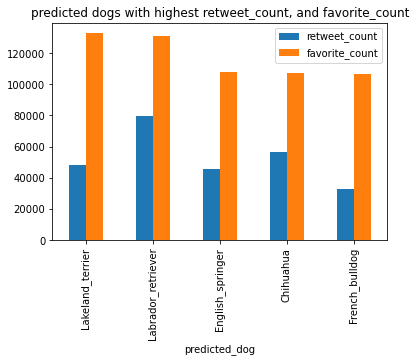

In [73]:
twitter_archive_master.groupby('predicted_dog')['retweet_count', 'favorite_count'].max().nlargest(5, 'favorite_count').plot(kind = 'bar', title = 'predicted dogs with highest retweet_count, and favorite_count');

> The top three predicted dogs with the highest favorite counts include:
>- Lakeland_terrier
>- Labrador_retriever
>- English_springer

### 4. What dog stage had the highest favorite counts?

C:\Users\Onyima Emmanuella\AppData\Local\Temp\ipykernel_3852\4114454871.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  twitter_archive_master.groupby('dog_stages')['retweet_count', 'favorite_count'].mean().nlargest(3, 'favorite_count').plot(kind = 'bar', title = 'Dog stage with the highest favorite_counts');


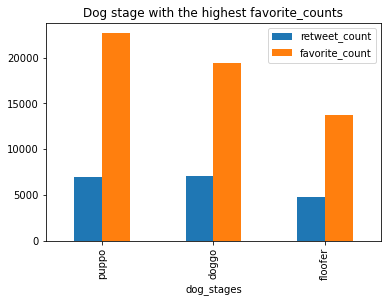

In [74]:
twitter_archive_master.groupby('dog_stages')['retweet_count', 'favorite_count'].mean().nlargest(3, 'favorite_count').plot(kind = 'bar', title = 'Dog stage with the highest favorite_counts');

> Puppo is the dog stage with the highest favorite count

### 5. Is there any relationship between the favorite_count and retweet_count?

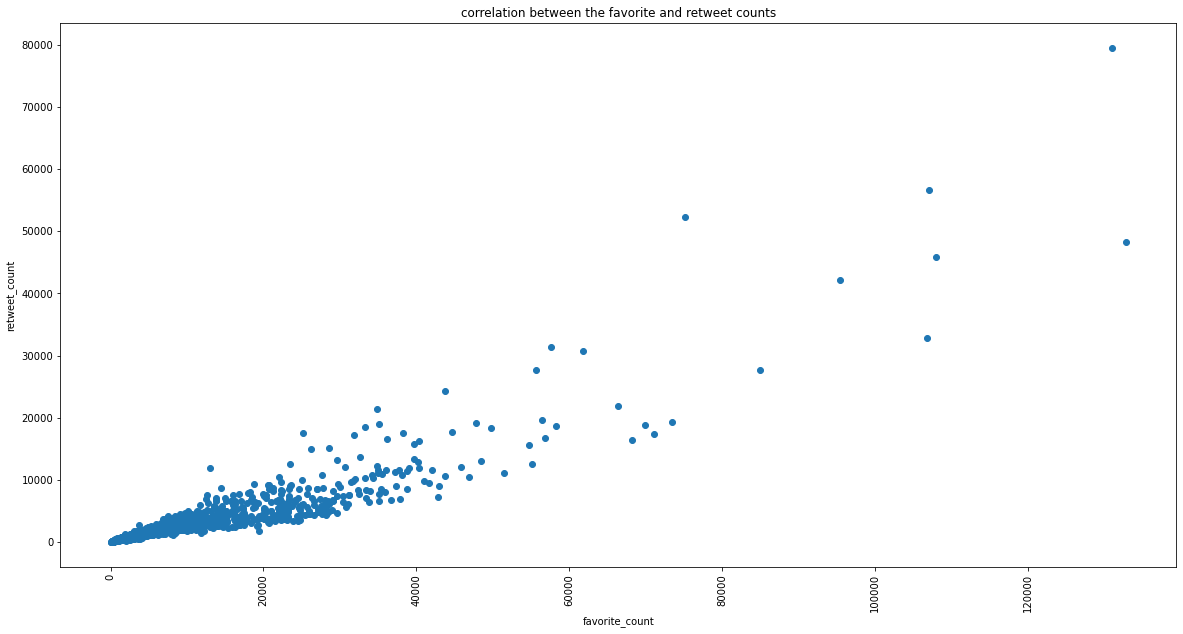

In [75]:
#ploting for the correlation between the favorite and retweet counts
plt.figure(figsize=[20,10])
plt.scatter(twitter_archive_master['favorite_count'], twitter_archive_master['retweet_count'])
plt.xticks(rotation = 90)
plt.ylabel('retweet_count')
plt.xlabel('favorite_count')
plt.title('correlation between the favorite and retweet counts')
plt.show()

> There is a positive correlation between the favorite_count and retweet count, meaning that there is an increase in the favorite_count corresponding to an increase in the retweet count.

### 6. Is there any relationship between the favorite_count and timestamp?

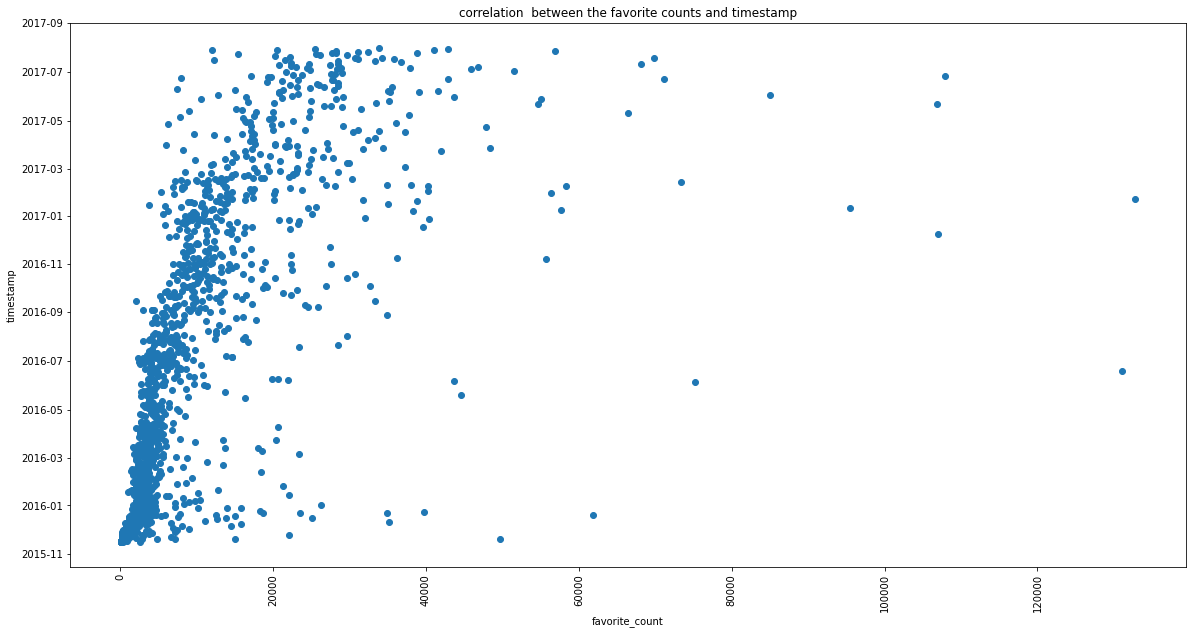

In [76]:
#ploting for the correlation  between the favorite counts and timestamp
plt.figure(figsize=[20,10])
plt.scatter(twitter_archive_master['favorite_count'], twitter_archive_master['timestamp'])
plt.xticks(rotation = 90)
plt.ylabel('timestamp')
plt.xlabel('favorite_count')
plt.title('correlation  between the favorite counts and timestamp')
plt.show()

>There is a positive correlation between the timestamp and the favorite_count which means that there was an increase in favorite count over time.

## Conclusion

#### From the information obtained in our analysis, the following conclusions can be gathered:

>1. The highest tweets occured between the November 2015  to January 2016 and decreased across 2017

>2. The highest favorite tweets occured on the 21st of january 2017 (2017-01-21 18:26:02+00:00)

>3. The top three predicted dogs with the highest favorite counts include:
>- Lakeland_terrier
>- Labrador_retriever
>- English_springer

>4. Puppo is the dog stage with the highest favorite count.

>5. There is a positive correlation between the favorite_count and retweet count, meaning that there is an increase in the favorite_count corresponding to an increase in the retweet count.

>6. There is a positive correlation between the timestamp and the favorite_count which means that there was an increase in favorite count over time